In [1]:
from pandas import DataFrame, concat, MultiIndex, Series
from collections import defaultdict
from pandas import concat
from numpy import nanstd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import itertools
from pandas import HDFStore, DataFrame
from tqdm.auto import tqdm
import pandas as pd
from scipy.stats import shapiro, anderson, ttest_ind
from statsmodels.stats.multitest import multipletests


def calculate_fold_df(data: DataFrame, n_folds: int) -> DataFrame:
    avgs = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(5),
    ).mean(axis=1)
    errs = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(n_folds),
    ).apply(lambda x: nanstd(x) / ((len(x - 1)) ** 0.5) if len(x) > 1 else 1, axis=1)
    stds = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(n_folds),
    ).apply(lambda x: nanstd(x), axis=1)
    return concat(
        [avgs, errs, stds],
        axis=1,
        keys=["Balanced Accuracy", "Standard Error", "Standard Deviation"],
    )


def concatenate_prepared_data(data: dict[str, DataFrame]) -> DataFrame:
    concated_df_dict: dict[DataFrame, Series] = {}
    sides: list[str] = ["left", "right", "lxrx", "rxlx"]
    for side in sides:
        concated_df_dict[side] = concat(
            [
                data[key][
                    ["Balanced Accuracy", "Standard Error", "Standard Deviation"]
                ].sort_index()
                for key in data.keys()
                if side in key
            ],
            axis=0,
            keys=[key[1:5] for key in data.keys() if side in key],
        )
        concated_df_dict[side].index = concated_df_dict[side].index.droplevel(0)

    all_results = concat(
        list(concated_df_dict.values()),
        axis=0,
        keys=sides,
        # ignore_index=True,
    )
    all_results = all_results.reset_index()
    all_results.columns = [
        "Side",
        "Model",
        "Balanced Accuracy",
        "Standard Error",
        "Standard Deviation",
    ]
    return all_results


def load_prepare_data(path_to_all_data: str, n_folds: int) -> DataFrame:
    loaded_data = defaultdict(lambda: defaultdict(lambda: dict()))

    # # Open the HDF5 file
    # with HDFStore(path_to_all_data) as store:
    #     # Iterate through the keys (group names) in the HDF5 file
    #     for key in tqdm(store.keys(), desc="Loading data"):
    #         # Load each DataFrame and store it in the dictionary
    #         data = store[key]
    #         split_key = key.split("_")
    #         loaded_data[split_key[0]][split_key[1]][split_key[2]] = data

    # loaded_data_correct = {
    #     f"{key1}_{key2}": calculate_fold_df(loaded_data[key1][key2], n_folds=n_folds)
    #     for key1 in loaded_data.keys()
    #     for key2 in loaded_data[key1].keys()
    # }

    # return concatenate_prepared_data(data=loaded_data_correct)
    with HDFStore(path_to_all_data) as store:
        # Iterate through the keys (group names) in the HDF5 file
        loaded_data = {
            key: store[key]
            for key in tqdm(store.keys(), desc="Loading data")
        }
        all_results = pd.concat(loaded_data.values(), axis=0, keys=loaded_data.keys(), names=["ID", "Model"])
        all_results = all_results.reset_index(inplace=False, drop=False)
        all_results['Side'] = all_results['ID'].apply(lambda x: x.split("_")[0])
        all_results['Random Seed'] = all_results['ID'].apply(lambda x: x.split("_")[1])
        all_results['Outer fold'] = all_results['ID'].apply(lambda x: x.split("_")[2])
        all_results = all_results.drop(columns=['ID'])
        return all_results


def remove_dummy(data: DataFrame) -> DataFrame:
    return data[data["Model"] != "DummyClassifier"]


def make_violin_accuracy(
    data: DataFrame,
    path_to_save_fig: str | None = None,
    small_fontsize: int = 14,
    medium_fontsize: int = 18,
    large_fontsize: int = 20,
    dummy_val: float = 0.5,
    xlim: tuple[float, float] | None = None,
):
    # set seaborn style
    sns.set_style("darkgrid")

    # # set latex font
    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    # plt.rcParams.update({"font.size": figsize *8})
    plt.rcParams["axes.grid"] = True

    # increase font size
    plt.rc("font", size=small_fontsize)  # controls default text sizes
    plt.rc("axes", titlesize=medium_fontsize)  # fontsize of the axes title
    plt.rc("axes", labelsize=large_fontsize)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("legend", fontsize=medium_fontsize)  # legend fontsize
    plt.rc("figure", titlesize=large_fontsize)  # fontsize of the figure title
    plt.rcParams.update({"font.size": medium_fontsize})

    ax = sns.violinplot(
        data=data,
        y="Train-Test",
        x="Balanced Accuracy",
        palette="colorblind",
        orient="h",
    )
    # annotator = Annotator(
    #     ax,
    #     list(itertools.combinations(sides, 2)),
    #     data=data,
    #     x="Balanced Accuracy",
    #     y="Train-Test",
    #     orient="h",
    #     order=sides,
    # )
    # annotator.configure(
    #     test="Wilcoxon",
    #     comparisons_correction="HB",
    #     text_format="star",
    #     loc="outside",
    # )
    # annotator.apply_and_annotate()

    # set vertical line at 0.5
    plt.axvline(x=dummy_val, color="black", linestyle="--", linewidth=1)
    if xlim:
        plt.xlim(xlim)
    if path_to_save_fig is not None:
        plt.savefig(path_to_save_fig, bbox_inches="tight")
    plt.show()


def clean_side_names(
    data: DataFrame, renaming_dict: dict[str, str] | None = None
) -> DataFrame:
    if renaming_dict is None:
        renaming_dict = {
            "left": "Left-Left",
            "right": "Right-Right",
            "lxrx": "Left-Right",
            "rxlx": "Right-Left",
        }
    renaming_dict: dict[str, str]
    data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)
    return data.rename(columns={"Side": "Train-Test"}, inplace=False)
    

def test_normality(all_xgb_results: dict) -> None:
    # test the normality of all three data distributions
    for side, data in all_xgb_results.items():
        print(f"Shapiro-Wilk test for normality on data set {side}:")
        print(shapiro(data["Balanced Accuracy"]))
        # make the histogram with kernel of the data distribution
        sns.distplot(
            data["Balanced Accuracy"],
            hist=True,
            kde=True,
            color="darkblue",
            hist_kws={"edgecolor": "black"},
            kde_kws={"linewidth": 4},
        )
        plt.show()
        print(f"Anderson-Darling test for normality on data set {side}:")
        print(anderson(data["Balanced Accuracy"]))


def simple_t_test(
    side_combinations: list[str], all_xgb_results: dict[str, DataFrame]
) -> dict[str, tuple]:
    t_test_results = {}
    for combination in side_combinations:
        el1 = all_xgb_results[combination[0]]["Balanced Accuracy"]
        el2 = all_xgb_results[combination[1]]["Balanced Accuracy"]
        t, p = ttest_ind(el1, el2)
        t_test_results[combination] = (t, p, p > 0.05)
    return t_test_results

from scipy import stats
from numpy import ndarray, mean, sqrt


def corrected_repeated_kfold_cv_test(
    a: ndarray, b: ndarray, n2: int, n1: int
) -> tuple[float, float]:
    if not isinstance(a, ndarray) or not isinstance(b, ndarray):
        raise ValueError("Inputs must be numpy arrays")
    x = a - b
    m = mean(x)
    sigma_squared = ((x - m) ** 2 / (len(x) - 1)).sum()
    denominator = 1 / len(x) + n2 / n1
    t = m / sqrt(denominator * sigma_squared)
    pval = stats.t.sf(abs(t), len(x)-1 + n1/n2) * 2
    return t, pval


def corrected_t_test(
    side_combinations: list[str], all_xgb_results: dict[str, DataFrame], n1, n2
) -> dict[str, tuple]:
    t_test_results = {}
    for combination in side_combinations:
        el1 = all_xgb_results[combination[0]]["Balanced Accuracy"]
        el2 = all_xgb_results[combination[1]]["Balanced Accuracy"]
        t, p = corrected_repeated_kfold_cv_test(el1.values, el2.values, n1=n1, n2=n2)
        t_test_results[combination] = (t, p, p > 0.05)
    
    p_values = [el[1] for el in t_test_results.values()]
    # apply p-value correction
    multi_hypothesis_result = multipletests(
    p_values,
    alpha=0.05,
    method="holm",
)   
    t_test_results = {
        key: (value[0], multi_hypothesis_result[1][i], multi_hypothesis_result[0][i])
        for i, (key, value) in enumerate(t_test_results.items())
    }
    return t_test_results


def cleanup_opposite_side_name(side_name: str) -> str:
    side_name = side_name[2:-1]
    sides = side_name.split(", ")
    train_side_name = sides[0]
    test_side_name = sides[1]
    return f"{train_side_name} -- {test_side_name}"

# USILaughs

In [69]:
path_to_save_data_avgs = "../data.nosync/usilaughs/results/loso_nested_all_bilateral_COMPLETE.h5"


# Create an empty dictionary to store the loaded DataFrames
all_results = load_prepare_data(path_to_save_data_avgs, n_folds=7)
all_results_no_dummy = remove_dummy(data=all_results)

Loading data:   0%|          | 0/48750 [00:00<?, ?it/s]

In [23]:
all_results_xgboost = all_results_no_dummy[all_results_no_dummy["Model"] == "XGBClassifier"]

In [34]:
# every use corresponds to a specific "outer fold"
all_results_xgboost['Side'].unique()

array(["('left', 'diff')", "('left', 'right')",
       "('left+diff', 'right+diff')", "('left+right', 'left+diff')",
       "('left+right', 'right+diff')", "('right', 'diff')", 'diff',
       'left+diff', 'left+right+diff', 'left+right', 'left', 'right+diff',
       'right'], dtype=object)

In [38]:
all_results_xgboost_mean = all_results_xgboost.groupby(['Side', 'Outer fold', 'Model']).mean()
all_results_xgboost_sem = all_results_xgboost.groupby(['Side', 'Outer fold', 'Model']).sem()

/tmp/ipykernel_1207089/1303283223.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_results_xgboost_mean = all_results_xgboost.groupby(['Side', 'Outer fold', 'Model']).mean()
/tmp/ipykernel_1207089/1303283223.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_results_xgboost_sem = all_results_xgboost.groupby(['Side', 'Outer fold', 'Model']).sem()


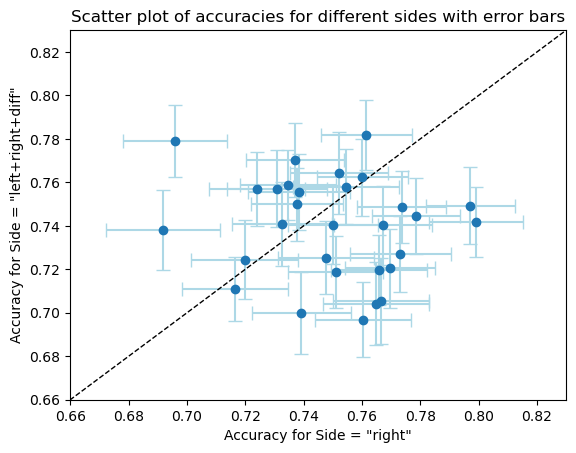

In [50]:
# Filter the data for the required sides
right_side_mean = all_results_xgboost_mean.loc['right']
left_right_diff_side_mean = all_results_xgboost_mean.loc['left+right+diff']

right_side_sem = all_results_xgboost_sem.loc['right']
left_right_diff_side_sem = all_results_xgboost_sem.loc['left+right+diff']

# Ensure the indices match for a proper scatter plot
right_side_mean = right_side_mean.reset_index()
left_right_diff_side_mean = left_right_diff_side_mean.reset_index()

right_side_sem = right_side_sem.reset_index()
left_right_diff_side_sem = left_right_diff_side_sem.reset_index()

# Merge the dataframes on 'Outer fold' and 'Model' to align the accuracies
merged_df_mean = pd.merge(right_side_mean, left_right_diff_side_mean, on=['Outer fold', 'Model'], suffixes=('_right', '_left_right_diff'))
merged_df_sem = pd.merge(right_side_sem, left_right_diff_side_sem, on=['Outer fold', 'Model'], suffixes=('_right', '_left_right_diff'))

# Create the scatter plot with error bars
plt.errorbar(
    merged_df_mean['Balanced Accuracy_right'],
    merged_df_mean['Balanced Accuracy_left_right_diff'],
    xerr=merged_df_sem['Balanced Accuracy_right'],
    yerr=merged_df_sem['Balanced Accuracy_left_right_diff'],
    fmt='o',
    ecolor='lightblue',
    capsize=5
)
plt.xlabel('Accuracy for Side = "right"')
plt.ylabel('Accuracy for Side = "left+right+diff"')
plt.title('Scatter plot of accuracies for different sides with error bars')

# make bisecting line
plt.plot([0.5, 1], [0.5, 1], color='black', linestyle='--', linewidth=1)

plt.xlim(0.66,0.83)
plt.ylim(0.66,0.83)
plt.show()


# add distribution over the 

# MWC2022

In [56]:
path_to_save_data_avgs = "../data.nosync/mwc2022/results/loso_nested_all_bilateral_COMPLETE.h5"


# Create an empty dictionary to store the loaded DataFrames
all_results = load_prepare_data(path_to_save_data_avgs, n_folds=7)
all_results_no_dummy = remove_dummy(data=all_results)
all_results_no_dummy['Side'] = all_results_no_dummy['Side'].apply(lambda x: x.replace("/", ""))

Loading data:   0%|          | 0/392 [00:00<?, ?it/s]

/tmp/ipykernel_1207089/4073528450.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_results_no_dummy['Side'] = all_results_no_dummy['Side'].apply(lambda x: x.replace("/", ""))


In [57]:
all_results_xgboost = all_results_no_dummy[all_results_no_dummy["Model"] == "XGBClassifier"]

In [58]:
all_results_xgboost_mean = all_results_xgboost.groupby(['Side', 'Outer fold', 'Model']).mean()
all_results_xgboost_sem = all_results_xgboost.groupby(['Side', 'Outer fold', 'Model']).sem()

/tmp/ipykernel_1207089/1303283223.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_results_xgboost_mean = all_results_xgboost.groupby(['Side', 'Outer fold', 'Model']).mean()
/tmp/ipykernel_1207089/1303283223.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_results_xgboost_sem = all_results_xgboost.groupby(['Side', 'Outer fold', 'Model']).sem()


In [63]:
all_results_xgboost["Side"].unique()

array(['diff', 'left+diff', 'left+right+diff', 'left+right', 'left',
       'right+diff', 'right'], dtype=object)

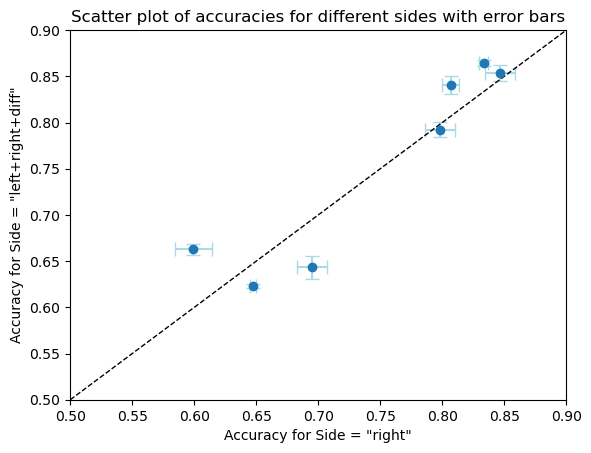

In [ ]:
# Filter the data for the required sides
right_side_mean = all_results_xgboost_mean.loc['left']
left_right_diff_side_mean = all_results_xgboost_mean.loc['left+right+diff']

right_side_sem = all_results_xgboost_sem.loc['left']
left_right_diff_side_sem = all_results_xgboost_sem.loc['left+right+diff']

# Ensure the indices match for a proper scatter plot
right_side_mean = right_side_mean.reset_index()
left_right_diff_side_mean = left_right_diff_side_mean.reset_index()

right_side_sem = right_side_sem.reset_index()
left_right_diff_side_sem = left_right_diff_side_sem.reset_index()

# Merge the dataframes on 'Outer fold' and 'Model' to align the accuracies
merged_df_mean = pd.merge(right_side_mean, left_right_diff_side_mean, on=['Outer fold', 'Model'], suffixes=('_right', '_left_right_diff'))
merged_df_sem = pd.merge(right_side_sem, left_right_diff_side_sem, on=['Outer fold', 'Model'], suffixes=('_right', '_left_right_diff'))

# Create the scatter plot with error bars
plt.errorbar(
    merged_df_mean['Balanced Accuracy_right'],
    merged_df_mean['Balanced Accuracy_left_right_diff'],
    xerr=merged_df_sem['Balanced Accuracy_right'],
    yerr=merged_df_sem['Balanced Accuracy_left_right_diff'],
    fmt='o',
    ecolor='lightblue',
    capsize=5
)
plt.xlabel('Accuracy for Side = "left"')
plt.ylabel('Accuracy for Side = "left+right+diff"')
plt.title('Scatter plot of accuracies for different sides with error bars')

# make bisecting line
plt.plot([0.5, 1], [0.5, 1], color='black', linestyle='--', linewidth=1)

plt.xlim(0.5,0.9)
plt.ylim(0.5,0.9)
plt.show()


# add distribution over the 